In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import  imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train_datagen=keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split=0.3)
train_dataset=train_datagen.flow_from_directory(directory='D:/RESEARCH/Circuit component recognition/train',
                                                target_size=(160,160),
                                                class_mode='categorical',
                                                subset='training',
                                                shuffle=True,
                                                batch_size=64)
validation_dataset=train_datagen.flow_from_directory(directory='D:/RESEARCH/Circuit component recognition/train',
                                                target_size=(160,160),
                                                class_mode='categorical',
                                                subset='validation',
                                                shuffle=True,
                                                batch_size=64)

test_datagen=keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_dataset=test_datagen.flow_from_directory(directory='D:/RESEARCH/Circuit component recognition/test',
                                                target_size=(160,160),
                                                class_mode='categorical',
                                                subset='training',
                                                shuffle=False,
                                                batch_size=64)


Found 7000 images belonging to 20 classes.
Found 3000 images belonging to 20 classes.
Found 2000 images belonging to 20 classes.


In [4]:
IMG_SHAPE = (224, 224, 3)

# Create the base model from the pre-trained model NAsNet Mobile
base_model = tf.keras.applications.nasnet.NASNetMobile(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [5]:
for layer in base_model.layers:
  layer.trainable=False

for i,layer in enumerate(base_model.layers):
  print(i,layer.name,'-',layer.trainable)

0 input_2 - False
1 stem_conv1 - False
2 stem_bn1 - False
3 activation_188 - False
4 reduction_conv_1_stem_1 - False
5 reduction_bn_1_stem_1 - False
6 activation_189 - False
7 activation_191 - False
8 separable_conv_1_pad_reduction_left1_stem_1 - False
9 separable_conv_1_pad_reduction_right1_stem_1 - False
10 separable_conv_1_reduction_left1_stem_1 - False
11 separable_conv_1_reduction_right1_stem_1 - False
12 separable_conv_1_bn_reduction_left1_stem_1 - False
13 separable_conv_1_bn_reduction_right1_stem_1 - False
14 activation_190 - False
15 activation_192 - False
16 separable_conv_2_reduction_left1_stem_1 - False
17 separable_conv_2_reduction_right1_stem_1 - False
18 activation_193 - False
19 separable_conv_2_bn_reduction_left1_stem_1 - False
20 separable_conv_2_bn_reduction_right1_stem_1 - False
21 separable_conv_1_pad_reduction_right2_stem_1 - False
22 activation_195 - False
23 reduction_add_1_stem_1 - False
24 separable_conv_1_reduction_right2_stem_1 - False
25 separable_conv_1_pa

In [6]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(20, activation='softmax')

In [4]:
import keras.backend as K
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [8]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',keras.metrics.Recall(name='recall'),keras.metrics.Precision(name='precision'),f1_score, keras.metrics.AUC(name='auc')])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 global_average_pooling2d (G  (None, 1056)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 20)                21140     
                                                                 
Total params: 4,290,856
Trainable params: 21,140
Non-trainable params: 4,269,716
_________________________________________________________________


In [10]:
validation_steps=150
initial_epochs = 150

In [11]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    monitor='val_accuracy',
    filepath='E:/data/nasnet.hdf5',
    save_best_only=True,
    mode='max',
    verbose=1
    )

In [12]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,verbose=1,callbacks=[model_checkpoint_callback],shuffle=True)

Epoch 1/150


C:\Users\SAPTARSHI PANI\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


110/110 [==============================] - ETA: 0s - loss: 2.8557 - accuracy: 0.1289 - recall: 1.4286e-04 - precision: 0.2500 - f1_score: 2.7972e-04 - auc: 0.6524
Epoch 1: val_accuracy improved from -inf to 0.22300, saving model to E:/data\nasnet.hdf5
110/110 [==============================] - 198s 2s/step - loss: 2.8557 - accuracy: 0.1289 - recall: 1.4286e-04 - precision: 0.2500 - f1_score: 2.7972e-04 - auc: 0.6524 - val_loss: 2.5424 - val_accuracy: 0.2230 - val_recall: 0.0017 - val_precision: 0.7143 - val_f1_score: 0.0033 - val_auc: 0.7997
Epoch 2/150
110/110 [==============================] - ETA: 0s - loss: 2.4200 - accuracy: 0.3104 - recall: 0.0029 - precision: 0.7407 - f1_score: 0.0056 - auc: 0.8535
Epoch 2: val_accuracy improved from 0.22300 to 0.38167, saving model to E:/data\nasnet.hdf5
110/110 [==============================] - 111s 1s/step - loss: 2.4200 - accuracy: 0.3104 - recall: 0.0029 - precision: 0.7407 - f1_score: 0.0056 - auc: 0.8535 - val_loss: 2.1853 - val_accuracy

Epoch 16/150
110/110 [==============================] - ETA: 0s - loss: 1.0036 - accuracy: 0.7801 - recall: 0.3580 - precision: 0.9425 - f1_score: 0.5162 - auc: 0.9865
Epoch 16: val_accuracy improved from 0.68433 to 0.69100, saving model to E:/data\nasnet.hdf5
110/110 [==============================] - 111s 1s/step - loss: 1.0036 - accuracy: 0.7801 - recall: 0.3580 - precision: 0.9425 - f1_score: 0.5162 - auc: 0.9865 - val_loss: 1.0271 - val_accuracy: 0.6910 - val_recall: 0.3783 - val_precision: 0.8401 - val_f1_score: 0.5188 - val_auc: 0.9781
Epoch 17/150
110/110 [==============================] - ETA: 0s - loss: 0.9705 - accuracy: 0.7907 - recall: 0.3769 - precision: 0.9445 - f1_score: 0.5363 - auc: 0.9873
Epoch 17: val_accuracy improved from 0.69100 to 0.69833, saving model to E:/data\nasnet.hdf5
110/110 [==============================] - 125s 1s/step - loss: 0.9705 - accuracy: 0.7907 - recall: 0.3769 - precision: 0.9445 - f1_score: 0.5363 - auc: 0.9873 - val_loss: 1.0015 - val_accur

Epoch 31/150
110/110 [==============================] - ETA: 0s - loss: 0.6811 - accuracy: 0.8550 - recall: 0.5739 - precision: 0.9517 - f1_score: 0.7149 - auc: 0.9939
Epoch 31: val_accuracy improved from 0.75100 to 0.75333, saving model to E:/data\nasnet.hdf5
110/110 [==============================] - 107s 978ms/step - loss: 0.6811 - accuracy: 0.8550 - recall: 0.5739 - precision: 0.9517 - f1_score: 0.7149 - auc: 0.9939 - val_loss: 0.7904 - val_accuracy: 0.7533 - val_recall: 0.5527 - val_precision: 0.8490 - val_f1_score: 0.6686 - val_auc: 0.9849
Epoch 32/150
110/110 [==============================] - ETA: 0s - loss: 0.6673 - accuracy: 0.8573 - recall: 0.5831 - precision: 0.9504 - f1_score: 0.7214 - auc: 0.9942
Epoch 32: val_accuracy improved from 0.75333 to 0.75767, saving model to E:/data\nasnet.hdf5
110/110 [==============================] - 105s 960ms/step - loss: 0.6673 - accuracy: 0.8573 - recall: 0.5831 - precision: 0.9504 - f1_score: 0.7214 - auc: 0.9942 - val_loss: 0.7800 - val

110/110 [==============================] - ETA: 0s - loss: 0.4306 - accuracy: 0.9077 - recall: 0.7737 - precision: 0.9591 - f1_score: 0.8560 - auc: 0.9977
Epoch 61: val_accuracy did not improve from 0.79367
110/110 [==============================] - 99s 904ms/step - loss: 0.4306 - accuracy: 0.9077 - recall: 0.7737 - precision: 0.9591 - f1_score: 0.8560 - auc: 0.9977 - val_loss: 0.6260 - val_accuracy: 0.7930 - val_recall: 0.6967 - val_precision: 0.8492 - val_f1_score: 0.7650 - val_auc: 0.9884
Epoch 62/150
110/110 [==============================] - ETA: 0s - loss: 0.4257 - accuracy: 0.9091 - recall: 0.7774 - precision: 0.9606 - f1_score: 0.8586 - auc: 0.9977
Epoch 62: val_accuracy improved from 0.79367 to 0.79633, saving model to E:/data\nasnet.hdf5
110/110 [==============================] - 101s 917ms/step - loss: 0.4257 - accuracy: 0.9091 - recall: 0.7774 - precision: 0.9606 - f1_score: 0.8586 - auc: 0.9977 - val_loss: 0.6200 - val_accuracy: 0.7963 - val_recall: 0.7017 - val_precision:

110/110 [==============================] - 99s 904ms/step - loss: 0.3659 - accuracy: 0.9210 - recall: 0.8206 - precision: 0.9639 - f1_score: 0.8855 - auc: 0.9984 - val_loss: 0.5842 - val_accuracy: 0.8037 - val_recall: 0.7297 - val_precision: 0.8478 - val_f1_score: 0.7840 - val_auc: 0.9892
Epoch 77/150
110/110 [==============================] - ETA: 0s - loss: 0.3624 - accuracy: 0.9211 - recall: 0.8226 - precision: 0.9650 - f1_score: 0.8880 - auc: 0.9984
Epoch 77: val_accuracy improved from 0.80500 to 0.80733, saving model to E:/data\nasnet.hdf5
110/110 [==============================] - 101s 928ms/step - loss: 0.3624 - accuracy: 0.9211 - recall: 0.8226 - precision: 0.9650 - f1_score: 0.8880 - auc: 0.9984 - val_loss: 0.5834 - val_accuracy: 0.8073 - val_recall: 0.7330 - val_precision: 0.8510 - val_f1_score: 0.7873 - val_auc: 0.9895
Epoch 78/150
110/110 [==============================] - ETA: 0s - loss: 0.3591 - accuracy: 0.9226 - recall: 0.8246 - precision: 0.9651 - f1_score: 0.8893 - au

Epoch 108/150
110/110 [==============================] - ETA: 0s - loss: 0.2786 - accuracy: 0.9410 - recall: 0.8816 - precision: 0.9703 - f1_score: 0.9238 - auc: 0.9992
Epoch 108: val_accuracy improved from 0.81633 to 0.81733, saving model to E:/data\nasnet.hdf5
110/110 [==============================] - 103s 939ms/step - loss: 0.2786 - accuracy: 0.9410 - recall: 0.8816 - precision: 0.9703 - f1_score: 0.9238 - auc: 0.9992 - val_loss: 0.5438 - val_accuracy: 0.8173 - val_recall: 0.7623 - val_precision: 0.8496 - val_f1_score: 0.8033 - val_auc: 0.9893
Epoch 109/150
110/110 [==============================] - ETA: 0s - loss: 0.2765 - accuracy: 0.9416 - recall: 0.8824 - precision: 0.9706 - f1_score: 0.9243 - auc: 0.9992
Epoch 109: val_accuracy did not improve from 0.81733
110/110 [==============================] - 95s 864ms/step - loss: 0.2765 - accuracy: 0.9416 - recall: 0.8824 - precision: 0.9706 - f1_score: 0.9243 - auc: 0.9992 - val_loss: 0.5411 - val_accuracy: 0.8170 - val_recall: 0.7630

Epoch 124/150
110/110 [==============================] - ETA: 0s - loss: 0.2490 - accuracy: 0.9486 - recall: 0.8999 - precision: 0.9736 - f1_score: 0.9354 - auc: 0.9994
Epoch 124: val_accuracy improved from 0.82100 to 0.82133, saving model to E:/data\nasnet.hdf5
110/110 [==============================] - 102s 933ms/step - loss: 0.2490 - accuracy: 0.9486 - recall: 0.8999 - precision: 0.9736 - f1_score: 0.9354 - auc: 0.9994 - val_loss: 0.5288 - val_accuracy: 0.8213 - val_recall: 0.7773 - val_precision: 0.8511 - val_f1_score: 0.8123 - val_auc: 0.9896
Epoch 125/150
110/110 [==============================] - ETA: 0s - loss: 0.2475 - accuracy: 0.9490 - recall: 0.8994 - precision: 0.9728 - f1_score: 0.9344 - auc: 0.9994
Epoch 125: val_accuracy did not improve from 0.82133
110/110 [==============================] - 97s 881ms/step - loss: 0.2475 - accuracy: 0.9490 - recall: 0.8994 - precision: 0.9728 - f1_score: 0.9344 - auc: 0.9994 - val_loss: 0.5292 - val_accuracy: 0.8207 - val_recall: 0.7767

Epoch 140/150
110/110 [==============================] - ETA: 0s - loss: 0.2250 - accuracy: 0.9551 - recall: 0.9153 - precision: 0.9768 - f1_score: 0.9445 - auc: 0.9995
Epoch 140: val_accuracy improved from 0.82367 to 0.82400, saving model to E:/data\nasnet.hdf5
110/110 [==============================] - 101s 921ms/step - loss: 0.2250 - accuracy: 0.9551 - recall: 0.9153 - precision: 0.9768 - f1_score: 0.9445 - auc: 0.9995 - val_loss: 0.5231 - val_accuracy: 0.8240 - val_recall: 0.7863 - val_precision: 0.8516 - val_f1_score: 0.8176 - val_auc: 0.9888
Epoch 141/150
110/110 [==============================] - ETA: 0s - loss: 0.2237 - accuracy: 0.9553 - recall: 0.9160 - precision: 0.9767 - f1_score: 0.9455 - auc: 0.9995
Epoch 141: val_accuracy did not improve from 0.82400
110/110 [==============================] - 96s 877ms/step - loss: 0.2237 - accuracy: 0.9553 - recall: 0.9160 - precision: 0.9767 - f1_score: 0.9455 - auc: 0.9995 - val_loss: 0.5220 - val_accuracy: 0.8233 - val_recall: 0.7857

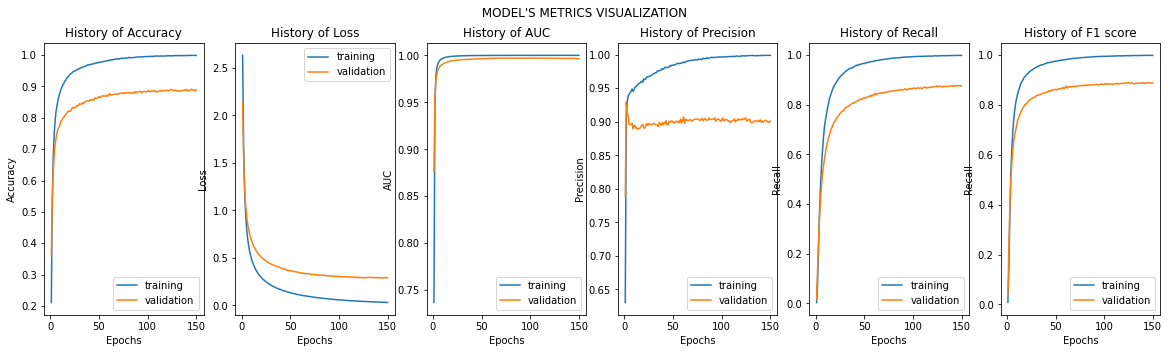

In [13]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,recall,val_recall,f1_score,val_f1_score):
    
    fig, (ax1, ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(recall) + 1), recall)
    ax5.plot(range(1, len(val_recall) + 1), val_recall)
    ax5.set_title('History of Recall')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('Recall')
    ax5.legend(['training', 'validation'])

    ax6.plot(range(1, len(f1_score) + 1), f1_score)
    ax6.plot(range(1, len(val_f1_score) + 1), val_f1_score)
    ax6.set_title('History of F1 score')
    ax6.set_xlabel('Epochs')
    ax6.set_ylabel('Recall')
    ax6.legend(['training', 'validation'])

    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['recall'],history.history['val_recall'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [13]:
model.save("E:/data/nasnet.hdf5")

name_last_layer = str(model.layers[-1])
name_seclast_layer = str(model.layers[-2])

model2 = keras.Sequential()
for layer in model.layers:
    if str(layer) != name_last_layer:
        if str(layer) != name_seclast_layer:
            model2.add(layer)
        
model2.summary()    

model2.save('E:/data/nasnet_mod.hdf5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
Total params: 4,269,716
Trainable params: 0
Non-trainable params: 4,269,716
_________________________________________________________________


In [5]:
model = keras.models.load_model("nasnet.hdf5", custom_objects={"f1_score": f1_score })
model.evaluate(test_dataset)

C:\Python\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


32/32 [==============================] - 43s 1s/step - loss: 0.5938 - accuracy: 0.7775 - recall: 0.7175 - precision: 0.8209 - f1_score: 0.7612 - auc: 0.9882


[0.5938284397125244,
 0.7774999737739563,
 0.7174999713897705,
 0.820938229560852,
 0.7612441182136536,
 0.9881835579872131]

C:\Users\aroy8\AppData\Local\Temp/ipykernel_13488/3963585414.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_dataset, 1157)
Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 1157 batches). You may need to use the repeat() function when building your dataset.


Confusion Matrix


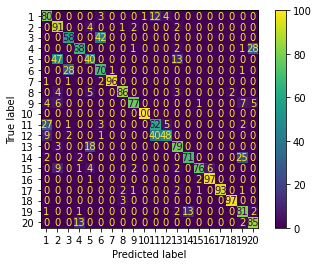

Classification Report
              precision    recall  f1-score   support

           1       0.65      0.80      0.71       100
           2       0.57      0.91      0.70       100
           3       0.64      0.58      0.61       100
           4       0.80      0.68      0.74       100
           5       0.56      0.40      0.47       100
           6       0.58      0.70      0.63       100
           7       0.99      0.96      0.97       100
           8       0.93      0.86      0.90       100
           9       0.93      0.77      0.84       100
          10       0.99      1.00      1.00       100
          11       0.54      0.62      0.58       100
          12       0.84      0.48      0.61       100
          13       0.75      0.79      0.77       100
          14       0.85      0.71      0.77       100
          15       0.95      0.76      0.84       100
          16       0.94      0.97      0.96       100
          17       1.00      0.93      0.96       100
     

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
Y_pred = model.predict_generator(test_dataset, 1157)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
disp = ConfusionMatrixDisplay(confusion_matrix(test_dataset.classes, y_pred),display_labels=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])
disp.plot()
plt.show()
print('Classification Report')
target_names = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
print(classification_report(test_dataset.classes, y_pred, target_names=target_names))